In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import sys
from pathlib import Path
from matplotlib import pyplot as plt

from ipywidgets import interact
import itertools

# set path to project directory
root_dir = Path.cwd().parents[1]
if not root_dir in sys.path:
    sys.path.insert(0, str(root_dir))
print(root_dir)

from placefield_dynamics.placefield_detection.utils import load_data
from placefield_dynamics.placefield_detection.utils import (
    gauss_smooth,
    get_spiking_data
)  

/home/wollex/Documents/Science/WolfGroup/PlaceFields/Programs/PC_analysis


# ToDo:
* how to find proper response window? -> check methods in papers and apply accordingly
* what to do with the 3 phases - aren't they too sparse to obtain a proper estimate of mean/max? (to obtain optimal phase response, ...)

## Questions
* what does CPD mean? -> cycles per degree (visual field)
* what is one "sequence" does it have any implications? or is it just 6 bundled up stimuli? is there an interruption after each "sequence"?
* what is stored in "grating"? Why is it 2049 times the same array?
* what are: flicker_repeats , depth_um, scanspeed, LPpercent, DegreesPerSecond, baseline_sec?
* does an exact mapping of imaging frame to time exist?
	- \# frames / 30.05 (firing rates) yields 815.90, vs the stimulus clock running until 813.01 - what's with the extra 4 secs?
	- stimulus clock starts at value > 0 (here 3.001s). Is the first imaging frame aligned with 0 secs?
	- did you make sure that frame acquisition is equally spaced over the whole period of measurement? is each frame taken exactly 1/30.05 sec from the previous one?
* where is the reference point? / what is the amplitude at certain points, accordingly?

In [2]:
folderPath = Path("../../../data/Subhodeep/ID20/20230913/")
# stimulusPath = folderPath / "ID20_1_230913.1_ipsi_stimProtocol_191.mat"
stimulusPath = folderPath / "ID20_1_230913.1_bino_stimProtocol_1820.mat"
# stimulusPath = folderPath / "ID20_1_230913.1_cont_stimProtocol_1840.mat"
caimanPath = folderPath / "results_CaImAn_20230913_20_00001_align.mat"

# print(folderPath.is_dir())
ld = load_data(stimulusPath)
data = ld["runInfo"]

## displays some information about the data
show_stats = False
if show_stats:
    for key in ld["runInfo"]:
        print(key, ld["runInfo"][key])
        try:
            print(key, ld["runInfo"][key].shape)
        except:
            pass

In [3]:
meta_data = load_data(folderPath / "CaimanMeta.mat")
# print(meta_data["CaimanMeta"].keys())
# print(meta_data["CaimanMeta"])

In [4]:
for path in Path.glob(folderPath, "*stimProtocol*"):
    print(path)

print("\n")
for path in Path.glob(folderPath, "results*.mat"):
    print(path)

../../../data/Subhodeep/ID20/20230913/ID20_1_230913.1_bino_stimProtocol_1820.mat
../../../data/Subhodeep/ID20/20230913/ID20_1_230913.1_ipsi_stimProtocol_191.mat
../../../data/Subhodeep/ID20/20230913/ID20_1_230913.1_cont_stimProtocol_1840.mat


../../../data/Subhodeep/ID20/20230913/results_CaImAn_20230913_20_00003_align_redetected_compares.mat
../../../data/Subhodeep/ID20/20230913/results_CaImAn_20230913_20_00002_align_redetected.mat
../../../data/Subhodeep/ID20/20230913/results_CaImAn_20230913_20_00002_align_redetected_compares.mat
../../../data/Subhodeep/ID20/20230913/results_CaImAn_20230913_20_00001_align_redetected.mat
../../../data/Subhodeep/ID20/20230913/results_CaImAn_20230913_20_00001_align_redetected_compares.mat
../../../data/Subhodeep/ID20/20230913/results_CaImAn_20230913_20_00001_align.mat
../../../data/Subhodeep/ID20/20230913/results_CaImAn_20230913_20_00003_align.mat
../../../data/Subhodeep/ID20/20230913/results_CaImAn_20230913_20_00002_align.mat
../../../data/Subhodeep/ID

## display some basic information on stimulus data

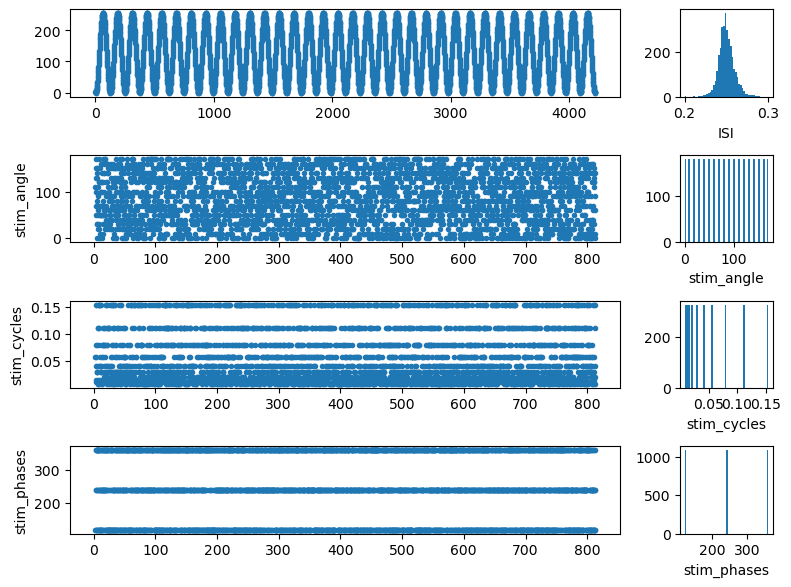

In [5]:
stimulus = ["stim_angle", "stim_cycles", "stim_phases"]

fig = plt.figure(figsize=(8, 7))

gs = fig.add_gridspec(5, 5)
ax = fig.add_subplot(gs[0, :-1])
ax.plot(data["grating"][0, :], ".")

ax = fig.add_subplot(gs[0, -1])
ax.hist(np.diff(data["stimulus_clock"][:, 0]), np.linspace(0.2, 0.3, 51))
plt.setp(ax, xlabel="ISI")

for i, stim in enumerate(stimulus):

    stim_data = data[stim].flatten()
    ax = fig.add_subplot(gs[i + 1, :-1])
    ax.plot(data["stimulus_clock"][:, 0], stim_data, ".", label=stim)
    plt.setp(ax, ylabel=stim)

    ax = fig.add_subplot(gs[i + 1, -1])
    ax.hist(
        stim_data, np.linspace(np.min(stim_data), np.max(stim_data), 51)
    )  # ,label=stim)
    plt.setp(ax, xlabel=stim)
plt.tight_layout()

## load neuron detection data and calculate stimulus-dependent firingmaps

In [6]:
# data["frame_times"].shape
data["stimulus_clock"]
data["stim_phases"]

array([[120, 360, 360, 120, 240, 120],
       [240, 240, 120, 120, 360, 360],
       [360, 360, 360, 360, 240, 240],
       ...,
       [120, 240, 240, 240, 240, 120],
       [360, 120, 120, 360, 120, 120],
       [240, 240, 120, 120, 360, 240]], shape=(540, 6), dtype=uint16)

In [7]:
caiman_data = load_data(caimanPath)
print(caiman_data["C"].shape)

data["frame_times"] = np.arange(caiman_data["C"].shape[1]) / 30.05
unique_values = {
    "phases": np.unique(data["stim_phases"]),
    "angles": data["angle"],
    "cycles": data["CPD"],
}

n_cells = caiman_data["C"].shape[0]
firing_maps = np.zeros(
    (
        len(unique_values["phases"]),
        len(unique_values["angles"]),
        len(unique_values["cycles"]),
        n_cells,
    )
)

dwelltime = np.zeros(
    (
        len(unique_values["phases"]),
        len(unique_values["angles"]),
        len(unique_values["cycles"]),
        n_cells,
    )
)

dStimulus = 0.25  # time to wait after stimulus onset before starting to count spikes
dResponse = 0.25

spikes = np.zeros((n_cells, len(data["frame_times"])))
for n in range(n_cells):
    spikes[n, :], _, _ = get_spiking_data(caiman_data["S"][n, :], f=30.05)
    # thr = np.percentile(caiman_data["S"][n, caiman_data["S"][n, :] > 0], 50)
    # spikes[n, :] = caiman_data["S"][n, :] / np.floor(thr)

for prod in itertools.product(
    enumerate(unique_values["phases"]),
    enumerate(unique_values["angles"]),
    enumerate(unique_values["cycles"]),
):
    idx, elems = zip(*prod)

    idxes = (
        (data["stim_phases"] == elems[0])
        & (data["stim_angle"] == elems[1])
        & (data["stim_cycles"] == elems[2])
    ).flatten()

    times = data["stimulus_clock"][idxes, :]
    for t, time in enumerate(times):
        start_idx = np.argmin(np.abs(data["frame_times"] - (time[0] + dStimulus)))
        # end_idx = np.argmin(np.abs(data["frame_times"] - time[1]))
        end_idx = np.argmin(
            np.abs(data["frame_times"] - (time[0] + dStimulus + dResponse))
        )

        firing_maps[idx[0], idx[1], idx[2], :] += np.sum(
            # caiman_data["S"][:, start_idx:end_idx]>0, axis=1
            spikes[:, start_idx:end_idx],
            # caiman_data["S"][:, start_idx:end_idx],
            axis=1,
        ) / (data["frame_times"][end_idx] - data["frame_times"][start_idx])

        dwelltime[idx[0], idx[1], idx[2], :] += (
            data["frame_times"][end_idx] - data["frame_times"][start_idx]
        )

(71, 24518)


In [8]:
unique_values["angles"].shape

(18,)

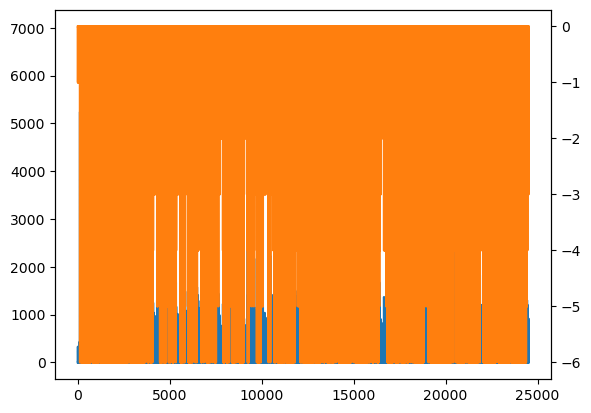

(71, 24518) 24430.65


In [ ]:
n = 1
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax2 = ax.twinx()
ax.plot(caiman_data["S"][n, :])
ax2.plot(-spikes[n, :], color="tab:orange")
plt.show()

print(spikes.shape, 813 * 30.05)

range(0, 20)


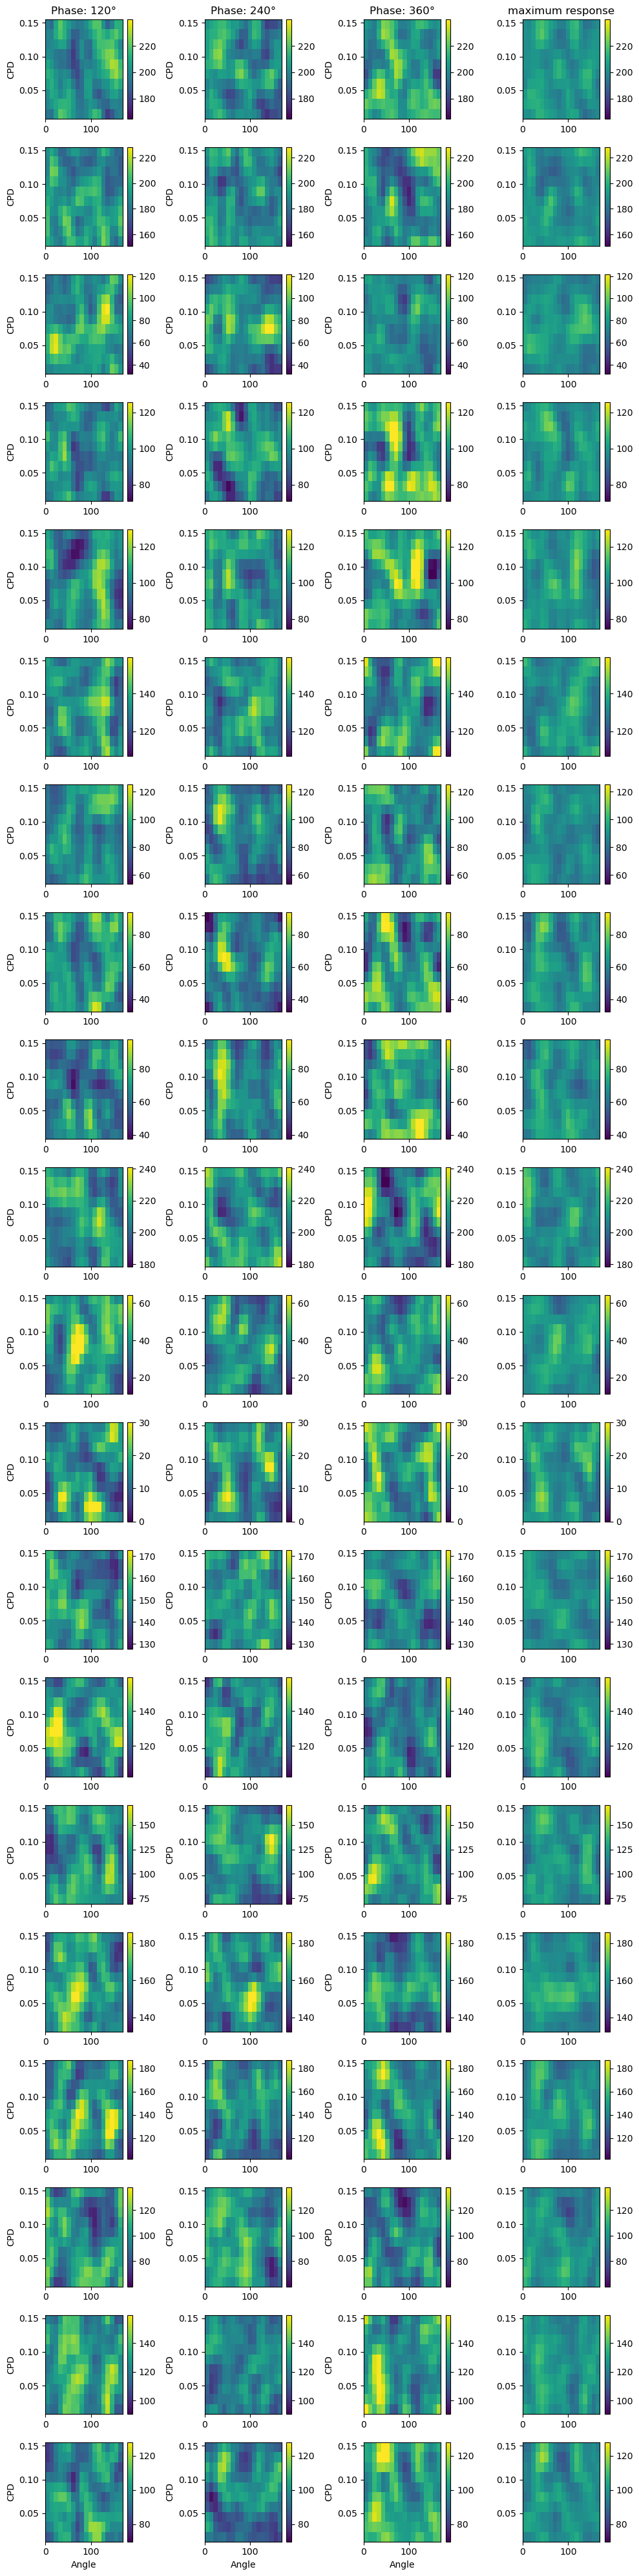

In [12]:
neurons = range(20)
print(neurons)
rows = len(neurons)

fig = plt.figure(figsize=(10, rows * 2))

cols = 4
gs = fig.add_gridspec(rows, cols)

# for n,(row,col) in enumerate(itertools.product(range(rows),range(cols))):
# clims = [0,100]
for row, n in enumerate(neurons):

    clims = np.percentile(firing_maps[..., n], [20, 80])
    for i, phase in enumerate(unique_values["phases"]):
        ax = fig.add_subplot(gs[row, i])
        img = ax.imshow(
            gauss_smooth(firing_maps[i, ..., n], (1.0, 1.0)).T,
            # gauss_smooth(firing_maps[i, ..., n + 0], 0).T,
            extent=[
                data["angle"].min(),
                data["angle"].max(),
                data["CPD"].min(),
                data["CPD"].max(),
            ],
            aspect="auto",
            origin="lower",
            clim=clims,
        )
        plt.colorbar(img)
        if row == 0:
            plt.setp(ax, title=f"Phase: {phase}°")

        if row == rows - 1:
            plt.setp(ax, xlabel="Angle")
        plt.setp(ax, ylabel="CPD")

    ax = fig.add_subplot(gs[row, 3])
    img = ax.imshow(
        # gauss_smooth(firing_maps[..., n].max(axis=0), (1.0, 1.0)).T,
        gauss_smooth(firing_maps[..., n].mean(axis=0), (1.0, 1.0)).T,
        # gauss_smooth(firing_maps[i, ..., n + 0], 0).T,
        extent=[
            data["angle"].min(),
            data["angle"].max(),
            data["CPD"].min(),
            data["CPD"].max(),
        ],
        aspect="auto",
        origin="lower",
        clim=clims,
    )
    if row == 0:
        plt.setp(ax, title=f"maximum response")
    plt.colorbar(img)

    plt.tight_layout()

In [10]:
n = 6
responses = firing_maps[..., n]


def get_prediction(responses, phase, smooth=False, plot=False):
    _, orientations, cycles = responses.shape
    phases = np.array([120, 240, 360]) * np.pi / 180  # Convert to radians
    # phases = np.array([120, 240]) * np.pi / 180  # Convert to radians

    # Fit sinusoidal model
    A = np.zeros((orientations, cycles))
    phi_0 = np.zeros((orientations, cycles))

    for i in range(orientations):
        for j in range(cycles):
            y = responses[:, i, j]
            x = phases
            # Fit the cosine model: y = A * cos(x - phi_0)
            A[i, j] = np.sqrt(
                (y * np.cos(x)).sum() ** 2 + (y * np.sin(x)).sum() ** 2
            ) / len(phases)
            phi_0[i, j] = np.arctan2((y * np.sin(x)).sum(), (y * np.cos(x)).sum())
    # print(phi_0)

    if smooth or plot:
        smoothed_phi = gauss_smooth(np.sin(phi_0), (1.0, 0.0), mode="wrap")
        smoothed_phi = gauss_smooth(smoothed_phi, (0.0, 1.0), mode="constant")
        smoothed_phi = np.arcsin(smoothed_phi)
    if plot:
        fig = plt.figure(figsize=(8, 3))
        ax = fig.add_subplot(121)
        img = ax.imshow(
            gauss_smooth(phi_0.T, (1.0, 1.0)),
            origin="lower",
            aspect="auto",
            cmap="bwr",
            clim=[-1, 1],
        )
        # img = ax.imshow(phi_0.T, origin="lower", aspect="auto",cmap='bwr',clim=[-3,3])
        plt.colorbar(img)
        ax = fig.add_subplot(122)
        # smoothed_phi = np.arcsin(gauss_smooth(np.sin(phi_0),(1.,1.)))
        img = ax.imshow(
            smoothed_phi.T, origin="lower", aspect="auto", cmap="bwr", clim=[-0.5, 0.5]
        )
        plt.colorbar(img)

    # Predict R_240
    phi_phase = phase * np.pi / 180  # Convert to radians
    if smooth:
        R_phase_pred = A * np.cos(phi_phase - smoothed_phi)
    else:
        R_phase_pred = A * np.cos(phi_phase - phi_0)

    return R_phase_pred

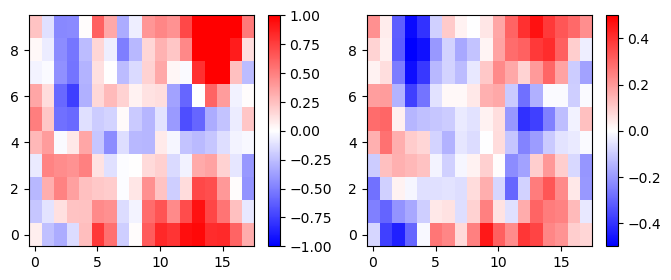

In [11]:
# vals = get_prediction(gauss_smooth(firing_maps[..., n],(0,2.,2.)), 120,plot=True)
vals = get_prediction(firing_maps[..., n], 240, plot=True)

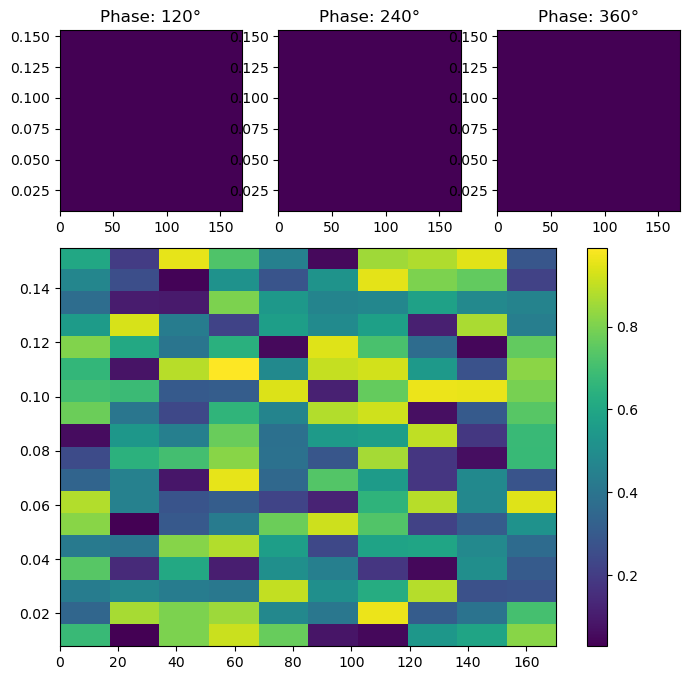

interactive(children=(IntSlider(value=0, description='phase', max=360, step=10), Output()), _dom_classes=('wid…

<Figure size 640x480 with 0 Axes>

In [154]:
plt.close("all")
# %matplotlib widget
fig = plt.figure(figsize=(8, 8))
gs = fig.add_gridspec(3, 3)
smooth_fact = 1.0

extents = [
    data["angle"].min(),
    data["angle"].max(),
    data["CPD"].min(),
    data["CPD"].max(),
]

phases = [120, 240, 360]
for i, phase in enumerate(phases):
    ax = fig.add_subplot(gs[0, i])
    ax.imshow(
        gauss_smooth(responses[i, ...], (smooth_fact, smooth_fact)).T,
        extent=extents,
        aspect="auto",
        origin="lower",
        clim=[6000, 11000],
    )
    plt.setp(ax, title=f"Phase: {phase}°")


phases = np.linspace(0, 300, 6)
ax = fig.add_subplot(gs[1:, :])
img = ax.imshow(
    np.random.rand(*responses.shape[1:]),
    cmap="viridis",
    aspect="auto",
    origin="lower",
    extent=extents,
)
# img.set_clim([-500,800])
plt.colorbar(img)


@interact(phase=(0, 360, 10))
def update_plot(phase=0):

    vals = gauss_smooth(
        get_prediction(firing_maps[..., n], phase, smooth=False),
        (smooth_fact, smooth_fact),
    )
    # print(vals)
    img.set_data(vals.T)
    img.set_clim([vals.min(), vals.max()])


plt.tight_layout()

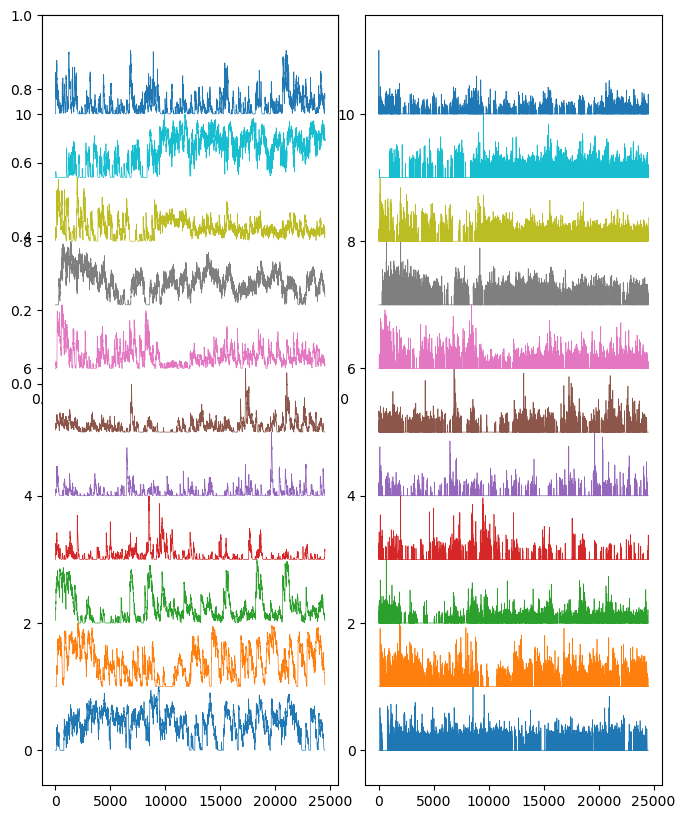

In [ ]:
# %matplotlib widget
fig = plt.figure(figsize=(8, 10))

gs = fig.add_gridspec(4, 4)
ax = fig.add_subplot(gs[:2, :2])

# dims = (512,512)
# Cn = np.zeros(dims)
# for a in caiman_data['A'].T:
#     # print(a.shape)
#     Cn += (a/a.sum()).reshape(dims)
# ax.imshow(Cn)

ax = fig.add_subplot(gs[:, :2])
for i, c in enumerate(caiman_data["C"]):
    ax.plot(c / c.max() + i, linewidth=0.5)
    if i >= 10:
        break

ax = fig.add_subplot(gs[:, 2:])
for i, s in enumerate(caiman_data["S"]):
    ax.plot(s / s.max() + i, linewidth=0.5)
    if i >= 10:
        break
# ax.plot()

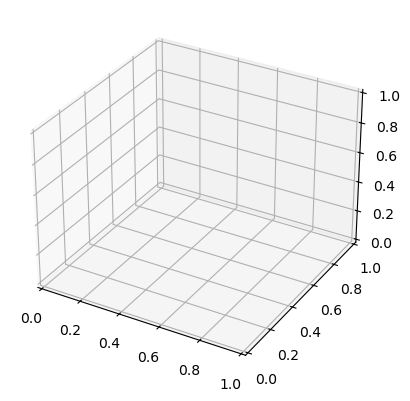

interactive(children=(FloatSlider(value=0.0, description='mean_x', max=180.0, min=-180.0, step=10.0), FloatSli…

In [15]:
import numpy as np
import matplotlib.pyplot as plt


def covariance_matrix(standard_deviation, theta):
    # Covariance matrix
    R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    Lambda = np.diag(standard_deviation**2)
    return R @ Lambda @ R.T


# Gaussian function
def multivariate_gaussian(pos, mu, Sigma):
    # n = mu.shape[0]
    diff = pos - mu
    inv_Sigma = np.linalg.inv(Sigma)
    det_Sigma = np.linalg.det(Sigma)
    norm_const = 1.0 / (2 * np.pi * np.sqrt(det_Sigma))
    result = np.einsum("...i,ij,...j->...", diff, inv_Sigma, diff)
    return norm_const * np.exp(-0.5 * result)


# Generate grid for visualization
x, y = np.linspace(-100, 100, 100), np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
# Z = multivariate_gaussian(pos, mu=np.zeros(2), Sigma=np.eye(2))
# img = ax.contour(X, Y, Z, levels=10, cmap='viridis')


@interact(
    mean_x=(-180, 180, 10.0),
    mean_y=(-1, 1, 0.1),
    sigma_x=(1.0, 50.0, 1.0),
    sigma_y=(0.01, 1, 0.01),
    theta=(0, 180, 10),
)
def update_plot(mean_x=0, mean_y=0, sigma_x=1, sigma_y=1, theta=0):

    theta *= np.pi / 180.0

    # Parameters
    mu = np.array([mean_x, mean_y])
    standard_deviation = np.array([sigma_x, sigma_y])

    Sigma = covariance_matrix(standard_deviation, theta)
    Z = multivariate_gaussian(pos, mu, Sigma)

    ax.clear()
    # ax.contour(X, Y, Z, levels=10, cmap="viridis")
    ax.plot_surface(X, Y, Z, cmap="viridis")
    # img.set_data(Z)


# Plot
plt.setp(ax, title="Rotated 2D Gaussian", xlabel="X-axis", ylabel="Y-axis")
ax.axis("equal")
plt.show()